### This example demonstrates the use of experience replay with XCSF
Uses the cart-pole problem from the [OpenAI Gym](https://gym.openai.com).

In [1]:
from __future__ import annotations

import random
from collections import deque
from typing import Final

import gym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image
from matplotlib import animation, rcParams
from tqdm import tqdm

import xcsf

### Initialise OpenAI Gym problem environment

In [2]:
env = gym.make("CartPole-v0")
X_DIM: Final[int] = env.observation_space.shape[0]
N_ACTIONS: Final[int] = env.action_space.n

### Initialise XCSF

In [3]:
# constructor = (x_dim, y_dim, n_actions)
xcs: xcsf.XCS = xcsf.XCS(X_DIM, N_ACTIONS, 1)  # Supervised: i.e, single action

xcs.OMP_NUM_THREADS = 8  # number of CPU cores to use
xcs.POP_INIT = False  # use covering to initialise
xcs.MAX_TRIALS = 1  # one trial per fit
xcs.POP_SIZE = 200  # maximum population size
xcs.E0 = 0.001  # target error
xcs.BETA = 0.05  # classifier parameter update rate
xcs.ALPHA = 1  # accuracy offset
xcs.NU = 5  # accuracy slope
xcs.EA_SUBSUMPTION = False
xcs.SET_SUBSUMPTION = False
xcs.THETA_EA = 100  # EA invocation frequency
xcs.THETA_DEL = 100  # min experience before fitness used for deletion

condition_layers: Final[dict] = {
    "layer_0": {  # hidden layer
        "type": "connected",
        "activation": "selu",
        "evolve_weights": True,
        "evolve_neurons": True,
        "n_init": 1,
        "n_max": 100,
        "max_neuron_grow": 1,
    },
    "layer_1": {  # output layer
        "type": "connected",
        "activation": "linear",
        "evolve_weights": True,
        "n_init": 1,
    },
}

xcs.condition("neural", condition_layers)  # neural network conditions
xcs.action("integer")  # (dummy) integer actions
xcs.prediction("rls_quadratic")  # Quadratic RLS

GAMMA: Final[float] = 0.95  # discount rate for delayed reward
epsilon: float = 1  # initial probability of exploring
EPSILON_MIN: Final[float] = 0.1  # the minimum exploration rate
EPSILON_DECAY: Final[float] = 0.98  # the decay of exploration after each batch replay
REPLAY_TIME: Final[int] = 1  # perform replay update every n episodes

print(xcs.json_parameters())

{
	"version":	"1.1.6",
	"x_dim":	4,
	"y_dim":	2,
	"n_actions":	1,
	"omp_num_threads":	8,
	"pop_init":	false,
	"max_trials":	1,
	"perf_trials":	1000,
	"pop_size":	200,
	"loss_func":	"mae",
	"set_subsumption":	false,
	"theta_sub":	100,
	"e0":	0.001,
	"alpha":	1,
	"nu":	5,
	"beta":	0.05,
	"delta":	0.1,
	"theta_del":	100,
	"init_fitness":	0.01,
	"init_error":	0,
	"m_probation":	10000,
	"stateful":	true,
	"compaction":	false,
	"ea":	{
		"select_type":	"roulette",
		"theta_ea":	100,
		"lambda":	2,
		"p_crossover":	0.8,
		"err_reduc":	1,
		"fit_reduc":	0.1,
		"subsumption":	false,
		"pred_reset":	false
	},
	"condition":	{
		"type":	"neural",
		"args":	{
			"layer_0":	{
				"type":	"connected",
				"activation":	"selu",
				"n_inputs":	4,
				"n_init":	1,
				"evolve_weights":	true,
				"evolve_functions":	false,
				"evolve_connect":	false,
				"evolve_neurons":	true,
				"n_max":	100,
				"max_neuron_grow":	1,
				"sgd_weights":	false
			},
			"layer_1":	{
				"type":	"connected",
				"activ

### Execute experiment

In [4]:
total_steps: int = 0  # total number of steps performed
MAX_EPISODES: Final[int] = 2000  # maximum number of episodes to run
N: Final[int] = 100  # number of episodes to average performance
memory: deque[tuple[np.ndarray, int, float, np.ndarray, bool]] = deque(maxlen=50000)
scores: deque[float] = deque(maxlen=N)  # used to calculate moving average

# for rendering an episode as a gif
SAVE_GIF: Final[bool] = True
SAVE_GIF_EPISODES: Final[int] = 50

frames: list[list[float]] = []
fscore: list[float] = []
ftrial: list[int] = []


def replay(replay_size: int = 5000) -> None:
    """Performs experience replay updates"""
    batch_size: Final[int] = min(len(memory), replay_size)
    batch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in batch:
        y_target = reward
        if not done:
            prediction_array = xcs.predict(next_state.reshape(1, -1))[0]
            y_target += GAMMA * np.max(prediction_array)
        target = xcs.predict(state.reshape(1, -1))[0]
        target[action] = y_target
        xcs.fit(state.reshape(1, -1), target.reshape(1, -1), True)


def egreedy_action(state: np.ndarray) -> int:
    """Selects an action using an epsilon greedy policy"""
    if np.random.rand() < epsilon:
        return random.randrange(N_ACTIONS)
    prediction_array = xcs.predict(state.reshape(1, -1))[0]
    # break ties randomly
    best_actions = np.where(prediction_array == prediction_array.max())[0]
    return int(np.random.choice(best_actions))


def episode(episode_nr: int, create_gif: bool) -> tuple[float, int]:
    """Executes a single episode, saving to memory buffer"""
    episode_score: int = 0
    episode_steps: int = 0
    state: np.ndarray = env.reset()
    while True:
        action = egreedy_action(state)
        next_state, reward, done, _ = env.step(action)
        episode_steps += 1
        episode_score += reward
        memory.append((state, action, reward, next_state, done))
        if create_gif:
            frames.append(env.render(mode="rgb_array"))
            fscore.append(episode_score)
            ftrial.append(episode_nr)
        if done:
            if create_gif:
                for _ in range(100):
                    frames.append(frames[-1])
                    fscore.append(fscore[-1])
                    ftrial.append(ftrial[-1])
            break
        state = next_state
    return episode_score, episode_steps


# learning episodes
for ep in range(MAX_EPISODES):
    gif: bool = False
    if SAVE_GIF and ep % SAVE_GIF_EPISODES == 0:
        gif = True
    # execute a single episode
    ep_score, ep_steps = episode(ep, gif)
    # perform experience replay updates
    if ep % REPLAY_TIME == 0:
        replay()
    # display performance
    total_steps += ep_steps
    scores.append(ep_score)
    mean_score = np.mean(scores)
    print(
        f"episodes={ep} "
        f"steps={total_steps} "
        f"score={mean_score:.2f} "
        f"epsilon={epsilon:.5f} "
        f"error={xcs.error():.5f} "
        f"msize={xcs.mset_size():.2f}"
    )
    # is the problem solved?
    if ep > N and mean_score > env.spec.reward_threshold:
        print(
            f"solved after {ep} episodes: "
            f"mean score {mean_score:.2f} > {env.spec.reward_threshold:.2f}"
        )
        break
    # decay the exploration rate
    if epsilon > EPSILON_MIN:
        epsilon *= EPSILON_DECAY

episodes=0 steps=14 score=14.00 epsilon=1.00000 error=0.53463 msize=0.88
episodes=1 steps=39 score=19.50 epsilon=0.98000 error=0.72869 msize=1.00
episodes=2 steps=57 score=19.00 epsilon=0.96040 error=0.78016 msize=2.55
episodes=3 steps=79 score=19.75 epsilon=0.94119 error=0.78722 msize=3.00
episodes=4 steps=98 score=19.60 epsilon=0.92237 error=0.83183 msize=5.00
episodes=5 steps=108 score=18.00 epsilon=0.90392 error=1.10252 msize=7.00
episodes=6 steps=124 score=17.71 epsilon=0.88584 error=0.76757 msize=10.89
episodes=7 steps=136 score=17.00 epsilon=0.86813 error=0.89761 msize=13.00
episodes=8 steps=152 score=16.89 epsilon=0.85076 error=1.06493 msize=16.32
episodes=9 steps=168 score=16.80 epsilon=0.83375 error=1.01346 msize=19.00
episodes=10 steps=186 score=16.91 epsilon=0.81707 error=1.17684 msize=23.00
episodes=11 steps=199 score=16.58 epsilon=0.80073 error=1.17408 msize=27.00
episodes=12 steps=213 score=16.38 epsilon=0.78472 error=1.15714 msize=31.00
episodes=13 steps=232 score=16.57

episodes=107 steps=5839 score=57.03 epsilon=0.11513 error=0.42271 msize=200.00
episodes=108 steps=5935 score=57.83 epsilon=0.11283 error=0.35085 msize=200.00
episodes=109 steps=6021 score=58.53 epsilon=0.11057 error=0.37014 msize=200.00
episodes=110 steps=6094 score=59.08 epsilon=0.10836 error=0.23339 msize=200.00
episodes=111 steps=6179 score=59.80 epsilon=0.10619 error=0.47728 msize=200.00
episodes=112 steps=6221 score=60.08 epsilon=0.10407 error=0.42808 msize=200.00
episodes=113 steps=6251 score=60.19 epsilon=0.10199 error=0.23570 msize=200.00
episodes=114 steps=6329 score=60.77 epsilon=0.09995 error=0.29473 msize=200.00
episodes=115 steps=6354 score=60.86 epsilon=0.09995 error=0.81153 msize=200.00
episodes=116 steps=6443 score=61.66 epsilon=0.09995 error=0.24746 msize=200.00
episodes=117 steps=6476 score=61.81 epsilon=0.09995 error=0.31435 msize=200.00
episodes=118 steps=6519 score=62.10 epsilon=0.09995 error=0.31300 msize=200.00
episodes=119 steps=6603 score=62.77 epsilon=0.09995 

episodes=210 steps=23165 score=170.71 epsilon=0.09995 error=0.26059 msize=164.37
episodes=211 steps=23330 score=171.51 epsilon=0.09995 error=0.10632 msize=158.73
episodes=212 steps=23530 score=173.09 epsilon=0.09995 error=0.09284 msize=168.20
episodes=213 steps=23730 score=174.79 epsilon=0.09995 error=0.07244 msize=174.97
episodes=214 steps=23930 score=176.01 epsilon=0.09995 error=0.11709 msize=172.62
episodes=215 steps=24130 score=177.76 epsilon=0.09995 error=0.09254 msize=159.77
episodes=216 steps=24330 score=178.87 epsilon=0.09995 error=0.08392 msize=169.74
episodes=217 steps=24521 score=180.45 epsilon=0.09995 error=0.06107 msize=185.07
episodes=218 steps=24721 score=182.02 epsilon=0.09995 error=0.20742 msize=156.77
episodes=219 steps=24912 score=183.09 epsilon=0.09995 error=0.11001 msize=156.16
episodes=220 steps=25112 score=183.66 epsilon=0.09995 error=0.07416 msize=168.41
episodes=221 steps=25307 score=184.25 epsilon=0.09995 error=0.06778 msize=167.48
episodes=222 steps=25507 sco

### Final exploit episode

In [5]:
epsilon = 0
ep_score, ep_steps = episode(ep, SAVE_GIF)
print(f"score = {ep_score}, steps = {ep_steps}")

score = 200.0, steps = 200


### Render the learning episodes

In [6]:
def save_frames_as_gif(path: str = "./", filename: str = "animation.gif") -> None:
    """Save animation as gif."""
    rcParams["font.family"] = "monospace"
    fig = plt.figure(dpi=90)
    fig.set_size_inches(3, 3)
    ax = fig.add_subplot(111)
    patch = plt.imshow(frames[0])
    bbox = dict(boxstyle="round", fc="0.8")
    plt.axis("off")

    bar = tqdm(total=len(frames), position=0, leave=True)  # progress bar

    def animate(i: int) -> None:
        patch.set_data(frames[i])
        strial = str(ftrial[i])
        sscore = str(int(fscore[i]))
        text = f"episode = {strial:3s}, score = {sscore:3s}"
        ax.annotate(text, xy=(0, 100), xytext=(-40, 1), fontsize=12, bbox=bbox)
        bar.refresh()
        bar.update(1)

    anim = animation.FuncAnimation(
        plt.gcf(), animate, frames=len(frames), interval=100, blit=False
    )
    anim.save(path + filename, writer="imagemagick", fps=30)

    bar.close()

Creating gif. This may take a while...


1319it [41:57,  1.91s/it]                                                                                                                                                                                  


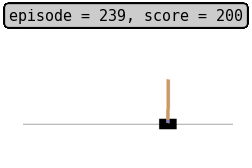

In [7]:
if SAVE_GIF:
    print("Creating gif. This may take a while...")
    save_frames_as_gif()

In [8]:
!gifsicle -O3 --colors=64 --use-col=web --lossy=100 --crop 0,10-270,220 --output out.gif animation.gif

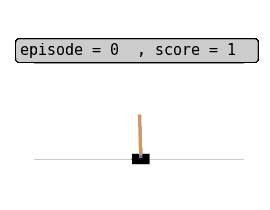

In [12]:
if SAVE_GIF:
    display(Image(open("out.gif", "rb").read()))

In [10]:
env.close()  # close Gym